In [1]:
import os
import sys
import time
import smbus

from math import log
from time import sleep
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

from meerkat import ads, thermistor

In [2]:
i2c = smbus.SMBus(1)
dev = ads.ADS1115(bus=i2c)
dev.get_config()
dev.pga('6.144')

In [3]:
dev.print_attributes()

ADS11x5 Configuration Attributes
--------------------------------
Config Register: 57600 0xe100 0b1110000100000000
PGA Range: +/- 6.144 Volts
Mode: single
Data Rate: 8 SPS
Input Multiplexer: 2G
Comparator:
 Queue: 1
 Latching: off
 Polarity: Active 1
 Mode: trad


In [4]:
def get_time():
    return datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')

In [5]:
def R2(R1, Vin, Vout):
    """Voltage divider, unknown resistance with known resistance and voltages"""
    return R1 * (1 / ((Vin/Vout) - 1))

In [8]:
# delay between reads and writes sometimes need to be increased
dev.delay = 0.1

# get voltages of pins
dev.mux('1G')     # pin 0 relative to ground
Vcc = dev.voltage()
time.sleep(1)
print('Measured Source voltage: {} V'.format(Vcc))
dev.mux('2G')     # pin 1 relative to ground
Vt = dev.voltage()
print('Measured Thermistor voltage: {} V'.format(Vt))

# calculate resistance of thermistor
Rt = R2(R1=10000, Vin=Vcc, Vout=Vt)
print('Measured resistance: {} ohms'.format(Rt))

# Thermistor is a Semitec 103AT-2 values from datasheet
# http://www.semitec.co.jp/uploads/english/sites/2/2017/03/P12-13-AT-Thermistor.pdf

# these steps would be done once
s103AT = thermistor.Semitec103AT()
A = thermistor.compose_array(*s103AT.find_nearest(Rt))
abc = thermistor.gauss(A)

tC = thermistor.steinhart_hart(Rt, *abc)
print('Measured temperature: {:6.2f} C'.format(tC))

Measured Source voltage: 2.04825 V
Measured Thermistor voltage: 0.9703125 V
Measured resistance: 9001.565489650375 ohms
Measured temperature:  27.83 C


In [30]:
samples = 200

In [31]:
data = []
for _ in range(samples):
    v = dev.voltage()
    r = R2(R1=10000, Vin=Vcc, Vout=v)
    T = thermistor.steinhart_hart(r, *abc)
    data.append([v, r, T])

In [32]:
df = pd.DataFrame(data, columns=['voltage', 'resistance', 'temperature_C'])

In [33]:
df.head()

,voltage,resistance,temperature_C
0,0.967125,8945.542837,28.001457
1,0.966375,8932.409012,28.041316
2,0.966375,8932.409012,28.041316
3,0.966000,8925.848926,28.061249
4,0.966000,8925.848926,28.061249


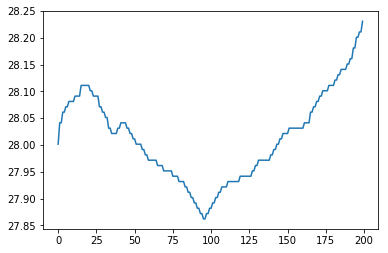

In [34]:
df.temperature_C.plot();